In [40]:
import sys
import pandas as pd
import rdflib
from typing import Dict, Any
import os
sys.path.append('/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/')

In [41]:
def get_sparql_question_meta(ttl_content: str) -> Dict[str, Any]:
    g = rdflib.Graph()
    g.parse(data=ttl_content, format='turtle')
    results = g.query(sparql_query)
    
    # Define the spex namespace for federatesWith
    spex = rdflib.Namespace("https://purl.expasy.org/sparql-examples/ontology#")
    
    for row in results:
        # Get all federatesWith values for this subject
        federates_with_list = [str(o) for o in g.objects(row.s, spex.federatesWith)]
        
        return {
            "resource": str(row.s),
            "natural_language_question": str(row.comment),
            "query": str(row.select),
            "target_endpoint": str(row.target),
            "federates_with": federates_with_list,
        }


In [42]:
import os
import pandas as pd
from experiments.utilities.format import get_sparql_question_meta



def process_specific_datasets_and_files(endpoint_files_map=None, dataset_dir=None) -> pd.DataFrame:
    """
    Process specific turtle files from specified endpoint sets and return their metadata as a DataFrame.
    
    Args:
        endpoint_files_map: Dictionary mapping endpoint sets to lists of specific TTL files to process
                           e.g., {"Uniprot": ["29.ttl", "20.ttl"], "Rhea": []}
                           Note: If an empty list is provided for a dataset, all files in that dataset will be processed
        dataset_dir: Directory containing the federated SPARQL dataset
        
    Returns:
        pandas DataFrame containing metadata for all processed files
    """

    # Set defaults if not provided
    if endpoint_files_map is None:
        endpoint_files_map = {"Uniprot": []}  # Default to Uniprot with all files (empty list)

    if dataset_dir is None:
        # Updated path to reflect new folder structure
        experiments_dir = os.path.dirname(os.path.dirname(__file__))
        dataset_dir = os.path.join(experiments_dir, "federated_sparql_dataset/examples_federated_02.04.2025")

    # Create a list to store metadata for all endpoint sets
    all_metadata = []
    total_processed_count = 0

    # Process each endpoint set in the map
    for endpoint_set, specific_files in endpoint_files_map.items():
        print(f"Processing endpoint set: {endpoint_set}")

        # Find the directory for this endpoint set (case-insensitive matching)
        endpoint_dir = None
        for item in os.listdir(dataset_dir):
            item_path = os.path.join(dataset_dir, item)
            if os.path.isdir(item_path) and item.lower() == endpoint_set.lower():
                endpoint_dir = item_path
                break

        if not endpoint_dir:
            print(f"Warning: Directory for endpoint set '{endpoint_set}' not found")
            continue

        # Process specific .ttl files in this endpoint directory
        endpoint_processed_count = 0

        for root, dirs, files in os.walk(endpoint_dir):
            for file in files:
                if file.endswith(".ttl") and (not specific_files or file in specific_files):
                    file_path = os.path.join(root, file)

                    # Read the turtle file
                    with open(file_path, "r", encoding="utf-8") as f:
                        content = f.read()

                    # Extract metadata using the function from format.py
                    meta_data = get_sparql_question_meta(content)
                    if meta_data:
                        # Add source endpoint information to the metadata
                        meta_data["endpoint_set"] = endpoint_set
                        meta_data["file_path"] = os.path.relpath(file_path, dataset_dir)
                        meta_data["filename"] = os.path.basename(file_path)

                        all_metadata.append(meta_data)
                        endpoint_processed_count += 1
                        #print(f"Processed: {file}")

        total_processed_count += endpoint_processed_count
        #print(f"Processed {endpoint_processed_count} files from {endpoint_set}")

    print(f"Created DataFrame with {total_processed_count} files from {len(endpoint_files_map)} endpoint sets")
    
    # Convert the list of metadata dictionaries to a DataFrame
    return pd.DataFrame(all_metadata)

In [43]:
# test_set = {
#     "SwissLipids": [
#         "16.ttl",
#         "34.ttl",
#         "6.ttl"
#     ],
#     "Uniprot": [
#         "116_biosodafrontend_rabit_mouse_orthologs.ttl",
#         "117_biosodafrontend_glioblastoma_orthologs_rat.ttl",
#         "118_biosodafrontend_rat_brain_human_cancer.ttl",
#         "29_search_uniprot_in_japanese_with_allie.ttl",
#         "36_orthologous_proteins_via_orthodb.ttl",
#         "38_find_gene_region_in_wikidata_for_known_entry.ttl",
#         "42_connect_patents_to_epo.ttl",
#         "43_patents_used_in_uniprot_granted_twenty_years_in_the_past.ttl",
#         "45_drugs_targeting_human_sterol_metabolism_enzymes.ttl",
#         "49_tissues_where_genes_metabolizing_cholestrol_are_expressed.ttl",
#         "51_all_proteins_linked_to_arachidonate.ttl",
#         "52_drugs_targeting_sterol_metabolism.ttl",
#         "53_mouse_homologs_of_sterol_enzymes_via_omabrowser.ttl",
#         "54_binding_sites_for_ligands_similar_to_heme_sachem.ttl",
#         "60_enzymes_working_on_substrate_with_Cholestene_backbone.ttl",
#         "67_draft_human_metabolome.ttl",
#         "70_enzymes_interacting_with_molecules_similar_to_dopamine.ttl"
#     ],
#     "Rhea": [
#         "109_Distribution_of_reactions_according_to_the_first_level_of_enzyme_classification.ttl",
#         "11.ttl",
#         "112_Total_number_of_reaction_ec_protein_links.ttl",
#         "115_Retrieve_the_set_of_metabolites_involved_in_reactions_catalyzed_by_human_genes_HUMAN_reference_proteome.ttl",
#         "117_Retrieve_parent_reactions_and_their_catalyzing_enzymes_for_a_metabolite_that_is_not_directly_involved_in_a_reaction.ttl",
#         "12.ttl",
#         "18.ttl",
#         "19_draft_human_metabolome.ttl",
#         "20_search_chemical_names_in_japanese.ttl"
#     ]
# }

In [44]:
df = process_specific_datasets_and_files(dataset_dir="/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/federated_sparql_dataset/examples_federated_19.04.2025", endpoint_files_map={"SwissLipids": [], "Uniprot": [], "Rhea": []})

Processing endpoint set: SwissLipids
Processing endpoint set: Uniprot
Processing endpoint set: Rhea
Created DataFrame with 32 files from 3 endpoint sets


In [45]:
similarity_comparision_set = {
    "SwissLipids": [
        "5.ttl"
    ],
    "Uniprot": [
        "40_human_enzymes_that_metabolize_sphingolipids.ttl"
    ],
    "Rhea": [
        "94_Select_all_approved_reactions_with_CHEBI_or_one_of_its_descendant_optional_UniProtKB_reviewed_EC.ttl"
    ]
}


In [46]:
# from fastembed import TextEmbedding
# import numpy as np
# from typing import List

# def compute_query_similarities(df, comparison_set):
#     embedding_model = TextEmbedding(model_name="BAAI/bge-large-en-v1.5")
    
#     comparison_files = [file for files in comparison_set.values() for file in files]
#     df_without_comparison = df[~df['filename'].isin(comparison_files)]
    
#     queries = df_without_comparison['query'].tolist()
#     all_embeddings = np.array(list(embedding_model.embed(queries)))
    
#     for endpoint, files in comparison_set.items():
#         for file in files:
#             comparison_row = df[df['filename'] == file].iloc[0]
#             comparison_query = comparison_row['query']
#             col_name = f"sim_{endpoint}_{file.split('.')[0]}"
#             comparison_embedding = np.array(list(embedding_model.embed([comparison_query])))[0]
#             similarities = np.dot(all_embeddings, comparison_embedding) / \
#                          (np.linalg.norm(all_embeddings, axis=1) * np.linalg.norm(comparison_embedding))
#             df_without_comparison[col_name] = similarities
    
#     return df_without_comparison

# df = process_specific_datasets_and_files(dataset_dir="/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/federated_sparql_dataset/examples_federated_19.04.2025", endpoint_files_map={"SwissLipids": [], "Uniprot": [], "Rhea": []})
# df_with_similarities = compute_query_similarities(df, similarity_comparision_set)

In [47]:

# for endpoint, files in similarity_comparision_set.items():
#     for file in files:
#         col_name = f"sim_{endpoint}_{file.split('.')[0]}"
#         print(f"\nTop 5 similar queries to {endpoint}/{file}:")
#         top_similar = df_with_similarities[df_with_similarities['filename'] != file]\
#             .sort_values(by=col_name, ascending=False)\
#             .head(10)
#         for _, row in top_similar.iterrows():
#             print(f"{row['filename']}: {row[col_name]:.3f}")

In [48]:
import numpy as np
from thefuzz import fuzz

def compute_query_fuzzy_similarities(df, comparison_set):
    comparison_files = [file for files in comparison_set.values() for file in files]
    df_without_comparison = df[~df['filename'].isin(comparison_files)]
    
    for endpoint, files in comparison_set.items():
        for file in files:
            comparison_row = df[df['filename'] == file].iloc[0]
            comparison_query = comparison_row['query']
            col_name = f"fuzz_{endpoint}_{file.split('.')[0]}"
            
            similarities = []
            for query in df_without_comparison['query']:
                ratio = fuzz.ratio(query, comparison_query) / 100.0
                similarities.append(ratio)
            
            df_without_comparison[col_name] = similarities
    
    return df_without_comparison

df = process_specific_datasets_and_files(dataset_dir="/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/federated_sparql_dataset/examples_federated_19.04.2025", endpoint_files_map={"SwissLipids": [], "Uniprot": [], "Rhea": []})
df_with_similarities = compute_query_fuzzy_similarities(df, similarity_comparision_set)

Processing endpoint set: SwissLipids
Processing endpoint set: Uniprot
Processing endpoint set: Rhea
Created DataFrame with 32 files from 3 endpoint sets


/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93549/2555493447.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_comparison[col_name] = similarities
/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93549/2555493447.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_comparison[col_name] = similarities
/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93549/2555493447.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [49]:
df_with_similarities.head()

,resource,natural_language_question,query,target_endpoint,federates_with,endpoint_set,file_path,filename,fuzz_SwissLipids_5,fuzz_Uniprot_40_human_enzymes_that_metabolize_sphingolipids,fuzz_Rhea_94_Select_all_approved_reactions_with_CHEBI_or_one_of_its_descendant_optional_UniProtKB_reviewed_EC
0,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/16.ttl,16.ttl,0.74,0.52,0.50
1,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/6.ttl,6.ttl,0.75,0.51,0.50
3,https://sparql.swisslipids.org/.well-known/spa...,Lipids affected by human enzymes,PREFIX owl: <http://www.w3.org/2002/07/owl#>\n...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/34.ttl,34.ttl,0.43,0.62,0.54
4,https://sparql.uniprot.org/.well-known/sparql-...,What are the Homo sapiens genes associated wit...,PREFIX up:<http://purl.uniprot.org/core/>\nPRE...,https://sparql.uniprot.org/sparql,"[https://sparql.omabrowser.org/sparql/, https:...",Uniprot,UniProt/118_biosodafrontend_rat_brain_human_ca...,118_biosodafrontend_rat_brain_human_cancer.ttl,0.36,0.39,0.42
5,https://sparql.uniprot.org/.well-known/sparql-...,Find all proteins linked to arachidonate (CHEB...,PREFIX CHEBI: <http://purl.obolibrary.org/obo/...,https://sparql.uniprot.org/sparql/,[https://sparql.rhea-db.org/sparql],Uniprot,UniProt/51_all_proteins_linked_to_arachidonate...,51_all_proteins_linked_to_arachidonate.ttl,0.46,0.60,0.50


In [50]:
def print_top_similarities(df_with_similarities, comparison_set, top_n=5):
    for endpoint, files in comparison_set.items():
        for file in files:
            col_name = f"fuzz_{endpoint}_{file.split('.')[0]}"
            print(f"\nTop {top_n} similar queries to {endpoint}/{file}:")
            
            # Sort by similarity score and get top matches
            top_matches = df_with_similarities.sort_values(by=col_name, ascending=False).head(top_n)
            
            # Print each match with details
            for idx, row in top_matches.iterrows():
                print(f"Similarity: {row[col_name]:.3f} | {row['endpoint_set']}/{row['filename']}")
                print(f"Query: {row['query'][:150]}..." if len(row['query']) > 150 else f"Query: {row['query']}")
                print("-" * 80)

print_top_similarities(df_with_similarities, similarity_comparision_set)


Top 5 similar queries to SwissLipids/5.ttl:
Similarity: 0.750 | SwissLipids/6.ttl
Query: PREFIX SWISSLIPID: <https://swisslipids.org/rdf/SLM_>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#...
--------------------------------------------------------------------------------
Similarity: 0.740 | SwissLipids/16.ttl
Query: PREFIX SWISSLIPID: <https://swisslipids.org/rdf/SLM_>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#...
--------------------------------------------------------------------------------
Similarity: 0.470 | Rhea/109_Distribution_of_reactions_according_to_the_first_level_of_enzyme_classification.ttl
Query: 
PREFIX rh:<http://rdf.rhea-db.org/>
PREFIX ec:<http://purl.uniprot.org/enzyme/>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos:<http...
--------------------------------------------------------------------------------
Similarity: 0.470 | Uniprot/67_draft_hu

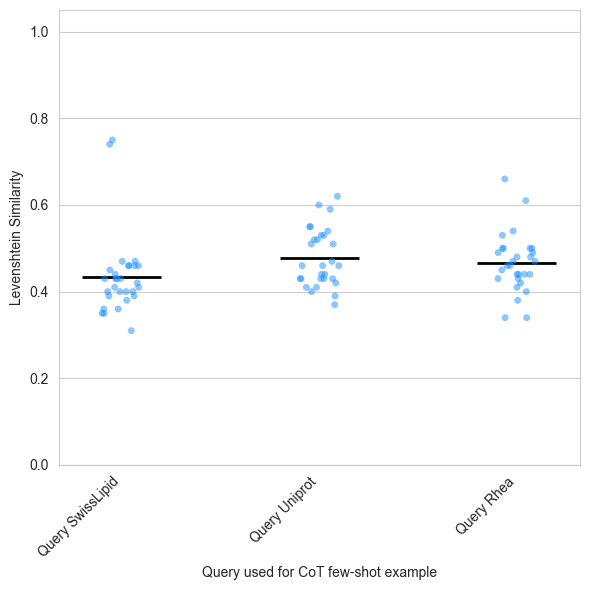

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_levenshtein_distances(df_with_similarities):
    col_mapping = {
        'fuzz_SwissLipids_5': 'Query SwissLipid',
        'fuzz_Uniprot_40_human_enzymes_that_metabolize_sphingolipids': 'Query Uniprot',
        'fuzz_Rhea_94_Select_all_approved_reactions_with_CHEBI_or_one_of_its_descendant_optional_UniProtKB_reviewed_EC': 'Query Rhea'
    }
    
    plot_data = []
    
    for idx, row in df_with_similarities.iterrows():
        for col, simple_name in col_mapping.items():
            plot_data.append({
                'Query Type': simple_name,
                'Levenshtein Similarity': row[col]
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(6, 6))
    sns.set_style("whitegrid")
    
    ax = sns.stripplot(
        data=plot_df,
        x='Query Type',
        y='Levenshtein Similarity',
        order=['Query SwissLipid', 'Query Uniprot', 'Query Rhea'],
        alpha=0.5,
        size=5,
        jitter=True,
        color='dodgerblue',
        edgecolor='none',
    )

    means = plot_df.groupby('Query Type')['Levenshtein Similarity'].mean()
    
    for i, query_type in enumerate(['Query SwissLipid', 'Query Uniprot', 'Query Rhea']):
        if query_type in means:
            mean_val = means[query_type]
            plt.hlines(y=mean_val, xmin=i-0.2, xmax=i+0.2, colors='black', linewidth=2)
    
    plt.xlabel('Query used for CoT few-shot example')
    plt.ylabel('Levenshtein Similarity')
    plt.xticks(rotation=45, ha='right')
    
    plt.ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig("./plots/levenshtein_similarity_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create the plot
plot_levenshtein_distances(df_with_similarities)

In [61]:
df.head()

,resource,natural_language_question,query,target_endpoint,federates_with,endpoint_set,file_path,filename
0,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/16.ttl,16.ttl
1,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/6.ttl,6.ttl
2,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,[https://sparql.rhea-db.org/sparql],SwissLipids,SwissLipids/5.ttl,5.ttl
3,https://sparql.swisslipids.org/.well-known/spa...,Lipids affected by human enzymes,PREFIX owl: <http://www.w3.org/2002/07/owl#>\n...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/34.ttl,34.ttl
4,https://sparql.uniprot.org/.well-known/sparql-...,What are the Homo sapiens genes associated wit...,PREFIX up:<http://purl.uniprot.org/core/>\nPRE...,https://sparql.uniprot.org/sparql,"[https://sparql.omabrowser.org/sparql/, https:...",Uniprot,UniProt/118_biosodafrontend_rat_brain_human_ca...,118_biosodafrontend_rat_brain_human_cancer.ttl


/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93549/869315516.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


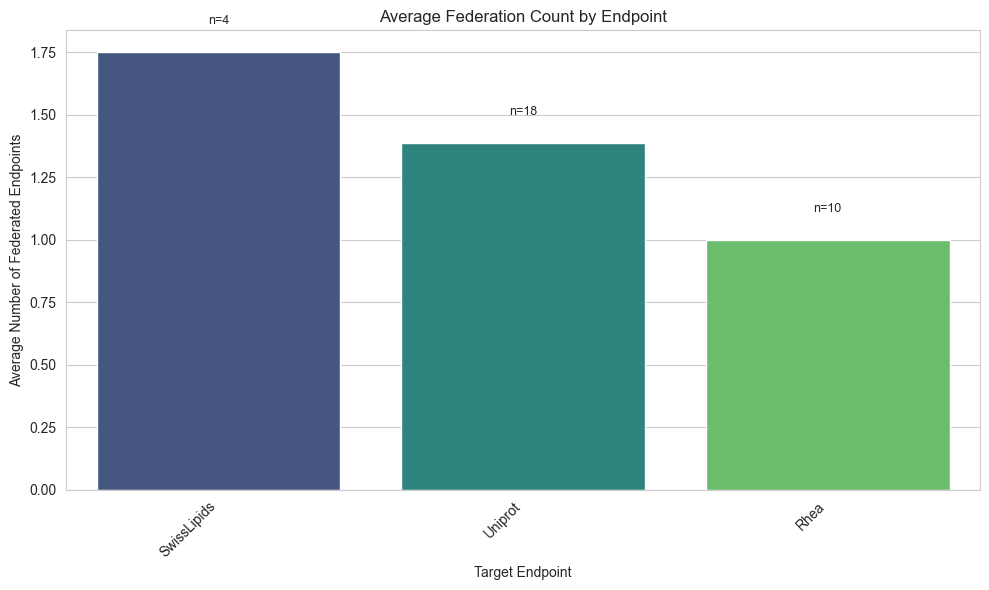

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_federation_patterns(df):
    federation_column = 'federates_with'
    
    df['federation_count'] = df[federation_column].apply(
        lambda x: len(x) if isinstance(x, list) else (0 if pd.isna(x) else 1)
    )
    
    federation_stats = df.groupby('endpoint_set')['federation_count'].agg(
        ['mean', 'median', 'min', 'max', 'count']
    ).reset_index()
    
    federation_stats = federation_stats.sort_values(by='mean', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    ax = sns.barplot(
        data=federation_stats,
        x='endpoint_set',
        y='mean',
        palette='viridis'
    )
    
    for i, row in enumerate(federation_stats.itertuples()):
        plt.text(
            i, 
            row.mean + 0.1, 
            f'n={row.count}',
            ha='center',
            va='bottom',
            fontsize=9
        )
    
    plt.xlabel('Target Endpoint')
    plt.ylabel('Average Number of Federated Endpoints')
    plt.title('Average Federation Count by Endpoint')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("./federation_by_endpoint.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return federation_stats

federation_stats = analyze_federation_patterns(df)

In [64]:
def analyze_federation_targets(df):
    federation_column = 'federates_with'
    
    all_federation_targets = {}
    
    for endpoint_set in df['endpoint_set'].unique():
        endpoint_df = df[df['endpoint_set'] == endpoint_set]
        
        federation_targets = []
        for fed_list in endpoint_df[federation_column]:
            if isinstance(fed_list, list):
                federation_targets.extend(fed_list)
        
        target_counts = pd.Series(federation_targets).value_counts().to_dict()
        all_federation_targets[endpoint_set] = target_counts
    
    for endpoint, targets in all_federation_targets.items():
        print(f"\nEndpoint: {endpoint}")
        print("Federates with:")
        for target, count in sorted(targets.items(), key=lambda x: x[1], reverse=True):
            print(f"  - {target}: {count} queries")
    
    return all_federation_targets

federation_targets = analyze_federation_targets(df)


Endpoint: SwissLipids
Federates with:
  - https://sparql.rhea-db.org/sparql: 4 queries
  - https://sparql.uniprot.org/sparql: 3 queries

Endpoint: Uniprot
Federates with:
  - https://sparql.rhea-db.org/sparql: 8 queries
  - https://sparql.omabrowser.org/sparql/: 3 queries
  - https://www.bgee.org/sparql/: 3 queries
  - https://idsm.elixir-czech.cz/sparql/endpoint/chebi: 3 queries
  - https://data.epo.org/linked-data/query: 2 queries
  - https://query.wikidata.org/sparql: 2 queries
  - https://sparql.omabrowser.org/sparql: 1 queries
  - https://idsm.elixir-czech.cz/sparql/endpoint/idsm: 1 queries
  - https://sparql.orthodb.org/sparql: 1 queries
  - https://data.allie.dbcls.jp/sparql: 1 queries

Endpoint: Rhea
Federates with:
  - https://sparql.uniprot.org/sparql: 6 queries
  - http://sparql.uniprot.org/sparql: 2 queries
  - https://data.allie.dbcls.jp/sparql: 1 queries
  - https://idsm.elixir-czech.cz/sparql/endpoint/chebi: 1 queries


In [ ]:
def find_duplicate_queries(df, similarity_threshold=0.9):
    n = len(df)
    high_similarity_pairs = []
    
    for i in range(n):
        query_i = df.iloc[i]['query']
        file_i = df.iloc[i]['filename']
        endpoint_i = df.iloc[i]['endpoint_set']
        
        for j in range(i+1, n):
            query_j = df.iloc[j]['query']
            file_j = df.iloc[j]['filename']
            endpoint_j = df.iloc[j]['endpoint_set']
            
            similarity = fuzz.ratio(query_i, query_j) / 100.0
            
            if similarity >= similarity_threshold:
                high_similarity_pairs.append({
                    'file1': file_i,
                    'endpoint1': endpoint_i,
                    'file2': file_j,
                    'endpoint2': endpoint_j,
                    'similarity': similarity
                })
    
    # Convert to DataFrame and sort by similarity
    if high_similarity_pairs:
        pairs_df = pd.DataFrame(high_similarity_pairs)
        pairs_df = pairs_df.sort_values(by='similarity', ascending=False)
        
        print(f"Found {len(pairs_df)} pairs with similarity >= {similarity_threshold}")
        return pairs_df
    else:
        print(f"No pairs found with similarity >= {similarity_threshold}")
        return pd.DataFrame()

# Find potential duplicates with 90% or higher similarity
duplicate_pairs = find_duplicate_queries(df, similarity_threshold=0.9)

# Display the top 20 most similar pairs
if not duplicate_pairs.empty:
    print("\nTop 20 most similar query pairs:")
    for _, row in duplicate_pairs.head(20).iterrows():
        print(f"\nSimilarity: {row['similarity']:.3f}")
        print(f"File 1: {row['endpoint1']}/{row['file1']}")
        print(f"File 2: {row['endpoint2']}/{row['file2']}")
        
        # Optionally, display the actual queries for the top few pairs
        if _ < 5:  # Show queries only for top 5 pairs
            query1 = df[df['filename'] == row['file1']]['query'].iloc[0]
            query2 = df[df['filename'] == row['file2']]['query'].iloc[0]

Found 1 pairs with similarity >= 0.9

Top 20 most similar query pairs:

Similarity: 0.920
File 1: SwissLipids/16.ttl
File 2: SwissLipids/6.ttl

Query 1:
PREFIX SWISSLIPID: <https://swisslipids.org/rdf/SLM_>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rh: <http://rdf.rhea-db.org/>
PREFIX up: <http://purl.uniprot.org/core/>

# Example 16
SELECT ?startId ?startName ?uniprot
WHERE
{
  # SwissL...

Query 2:
PREFIX SWISSLIPID: <https://swisslipids.org/rdf/SLM_>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rh: <http://rdf.rhea-db.org/>
PREFIX up: <http://purl.uniprot.org/core/>

# Example 6
SELECT ?startId ?startName ?chebi ?rhea ?rheaEquation ?...
--------------------------------------------------------------------------------
